# 1. Classification
To classify a new query into one of the 24 question types defined in MedInfo2019-QA-Medications, we plan to use different methods and analyze the comparison.

| Question Type            | # Queries | Example                                                                 |
|--------------------------|-----------|-------------------------------------------------------------------------|
| Information              | 112       | What type of drug is amphetamine?                                      |
| Dose                     | 70        | What is a daily amount of prednisolone eye drops to take?              |
| Usage                    | 61        | How to self inject enoxaparin sodium?                                  |
| Side Effects             | 60        | Does benazepril aggravate hepatitis?                                   |
| Indication               | 55        | Why is pyridostigmine prescribed?                                      |
| Interaction              | 51        | Can I drink Cataflam when I drink Medrol?                              |
| Action                   | 39        | How Xarelto affects in the process of homeostasis?                     |
| Appearance               | 38        | What color is 30mg prednisone?                                         |
| Usage/time               | 36        | When is the best time to take Lotensin?                                |
| Stopping/tapering        | 31        | How to come off citalopram?                                            |
| Ingredient               | 28        | What opioid is in the bupropion patch?                                 |
| Action/time              | 23        | How soon does losartan affect blood pressure?                          |
| Storage and disposal     | 13        | In how much temp BCG vaccine should store?                             |
| Comparison               | 11        | Why is Losartan prescribed rather than a calcium channel blocker?      |
| Contraindication         | 11        | If I am allergic to sulfa can I take glipizide?                        |
| Overdose                 | 10        | What happens if your child ate a Tylenol tablet?                       |
| Alternatives             | 8         | What medicine besides statins lower cholesterol?                       |
| Usage/duration           | 7         | How long should I take dutasteride?                                    |
| Time (other time types)  | 6         | How long are you protected after taking the hep B vaccine?             |
| Brand names              | 3         | What is brand name of acetaminophen?                                   |
| Combination              | 3         | How to combine dapagliflozin with metformin?                           |
| Pronunciation            | 3         | How do you pronounce Humira?                                           |
| Manufacturer             | 2         | Who makes this drug nitrofurantoin?                                    |
| Availability             | 1         | Has lisinopril been taken off the market?                              |
| Long term consequences   | 1         | What are the side effects and long term consequences of using nicotine?|


## 1.1 Load dataset

In [1]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from Algo import *


## 1.2 Embed the text

In [2]:
# # preprocessing
# embed_questions_from_xlsx("Dataset/MedInfo2019-filtered.xlsx", "Checkpoints/question_embeddings.npy")


In [3]:
# load preprocessed embeddings
embeddings, question_types = load_embeddings("Checkpoints/question_embeddings.npy")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    embeddings, question_types, test_size=0.2, random_state=42
)

## 1.3 Different classification model

### 1.3.1 KNN

Performing cross-validation for different K values...


100%|██████████| 20/20 [00:01<00:00, 19.11it/s]


Best K value: 1 with accuracy: 0.4400
Validation accuracy with K=1: 0.4844


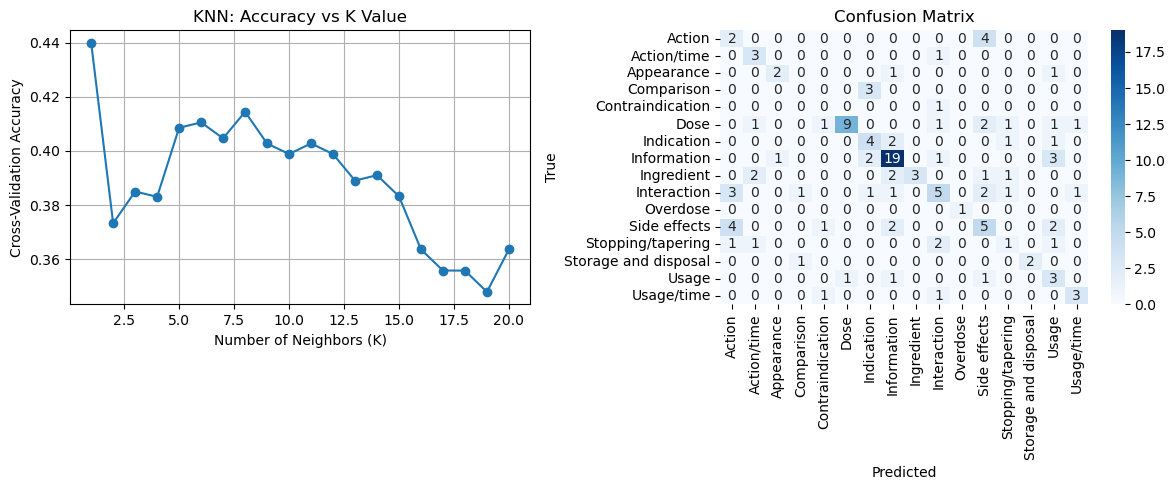

In [4]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Convert to numpy arrays for easier handling
X_train_array = np.array(X_train)
X_val_array = np.array(X_val)

# Define a range of K values to test
k_values = range(1, 21)
cv_scores = []

# Perform cross-validation for each K value
print("Performing cross-validation for different K values...")
for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_array, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the best K value
best_k = k_values[np.argmax(cv_scores)]
print(f"Best K value: {best_k} with accuracy: {max(cv_scores):.4f}")

# Train the KNN model with the best K value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_array, y_train)

# Evaluate on validation set
y_pred = best_knn.predict(X_val_array)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy with K={best_k}: {val_accuracy:.4f}")

# Plot the cross-validation results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, cv_scores, marker='o', linestyle='-')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN: Accuracy vs K Value')
plt.grid(True)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_val, y_pred)
# Get unique class labels
unique_labels = np.unique(question_types)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, 
            yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()


### 1.3.2 Random forest 

n_estimators=10, Cross-Validation Accuracy: 0.3360
n_estimators=50, Cross-Validation Accuracy: 0.4381
n_estimators=100, Cross-Validation Accuracy: 0.4460
n_estimators=200, Cross-Validation Accuracy: 0.4597
n_estimators=300, Cross-Validation Accuracy: 0.4519
Best number of trees: 200 with accuracy: 0.4597
Validation accuracy with 200 trees: 0.4766


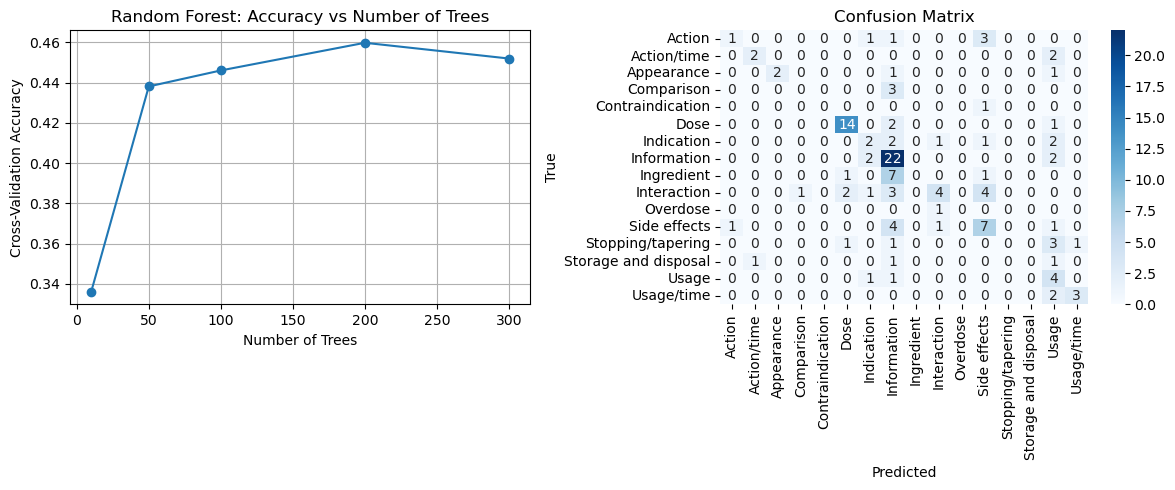

In [5]:
# Random Forest with cross-validation for different numbers of trees
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the range of n_estimators (number of trees) to try
n_estimators_values = [10, 50, 100, 200, 300]
cv_scores = []

# Perform cross-validation for each number of trees
for n_estimators in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    scores = cross_val_score(rf, X_train_array, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))
    print(f"n_estimators={n_estimators}, Cross-Validation Accuracy: {np.mean(scores):.4f}")

# Find the best number of trees
best_n_estimators = n_estimators_values[np.argmax(cv_scores)]
print(f"Best number of trees: {best_n_estimators} with accuracy: {max(cv_scores):.4f}")

# Train the Random Forest model with the best number of trees
best_rf = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
best_rf.fit(X_train_array, y_train)

# Evaluate on validation set
y_pred = best_rf.predict(X_val_array)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy with {best_n_estimators} trees: {val_accuracy:.4f}")

# Plot the cross-validation results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_estimators_values, cv_scores, marker='o', linestyle='-')
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Random Forest: Accuracy vs Number of Trees')
plt.grid(True)

# Plot the confusion matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_val, y_pred)
# Get unique class labels
unique_labels = np.unique(question_types)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, 
            yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Feature importance
feature_importances = best_rf.feature_importances_
# Get feature names (assuming they are available)
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    feature_names = [f"feature_{i}" for i in range(X_train_array.shape[1])]

### 1.3.3 SVM


Performing grid search for SVM...
Best parameters: {'C': 8, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.5618
Validation accuracy with best parameters: 0.5625


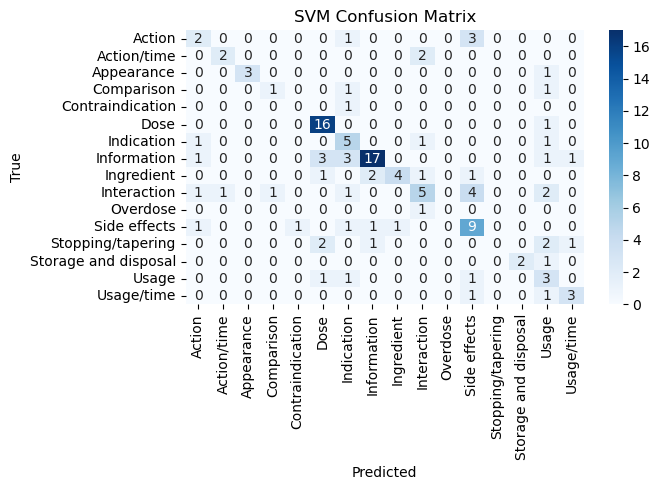

In [6]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 5, 8, 10, 20],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Use GridSearchCV to find the best parameters
print("Performing grid search for SVM...")
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_array, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

# Train the SVM model with the best parameters
best_svm = SVC(**best_params, random_state=42, probability=True)
best_svm.fit(X_train_array, y_train)

# Evaluate on validation set
y_pred = best_svm.predict(X_val_array)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy with best parameters: {val_accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_val, y_pred)
# Get unique class labels
unique_labels = np.unique(question_types)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, 
            yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')


plt.tight_layout()
plt.show()


### 1.3.4 Resnet-50

Using device: mps
Epoch 1/100, Train Loss: 2.6677, Train Acc: 0.1454, Val Loss: 2.7320, Val Acc: 0.1328
Epoch 2/100, Train Loss: 2.3644, Train Acc: 0.2593, Val Loss: 3.0736, Val Acc: 0.0391
Epoch 3/100, Train Loss: 1.9892, Train Acc: 0.4165, Val Loss: 2.5322, Val Acc: 0.1719
Epoch 4/100, Train Loss: 1.4909, Train Acc: 0.5914, Val Loss: 2.2673, Val Acc: 0.3125
Epoch 5/100, Train Loss: 0.9777, Train Acc: 0.7701, Val Loss: 2.7868, Val Acc: 0.1797
Epoch 6/100, Train Loss: 0.6806, Train Acc: 0.8468, Val Loss: 2.3123, Val Acc: 0.2969
Epoch 7/100, Train Loss: 0.4601, Train Acc: 0.9037, Val Loss: 2.7431, Val Acc: 0.2578
Epoch 8/100, Train Loss: 0.3246, Train Acc: 0.9391, Val Loss: 2.3384, Val Acc: 0.3281
Epoch 9/100, Train Loss: 0.2579, Train Acc: 0.9528, Val Loss: 2.5106, Val Acc: 0.3359
Epoch 10/100, Train Loss: 0.2318, Train Acc: 0.9646, Val Loss: 2.5150, Val Acc: 0.3750
Epoch 11/100, Train Loss: 0.1619, Train Acc: 0.9804, Val Loss: 2.5397, Val Acc: 0.3438
Epoch 12/100, Train Loss: 0.1269, 

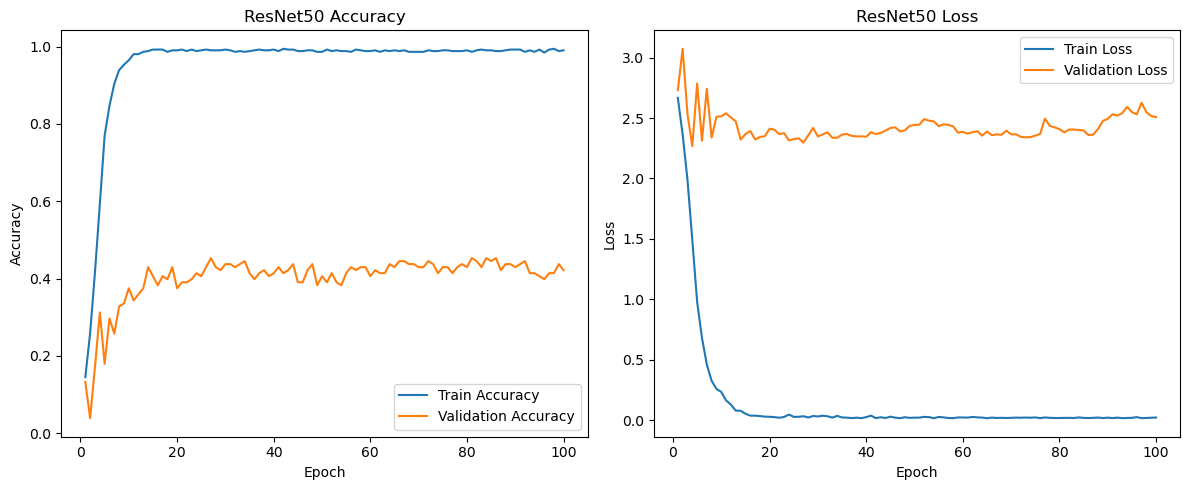

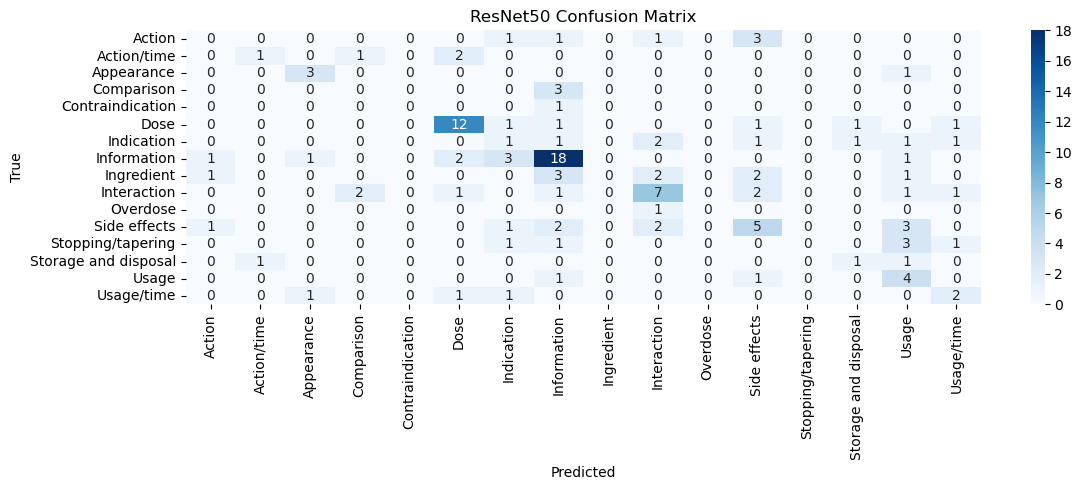

Final validation accuracy: 0.4219


In [7]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

# load preprocessed embeddings
embeddings, question_types = load_embeddings("Checkpoints/question_embeddings.npy")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    embeddings, question_types, test_size=0.2, random_state=42
)

# Check if CUDA or MPS is available
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Create ResNet50 model
def resnet50(num_classes=len(label_encoder.classes_)):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

model = resnet50().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Train the model
num_epochs = 100
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, all_preds, all_labels = validate_model(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet50 Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet50 Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Get final predictions and plot confusion matrix
_, _, final_preds, final_labels = validate_model(model, val_loader, criterion, device)

# Plot confusion matrix
plt.figure(figsize=(12, 5))
cm = confusion_matrix(final_labels, final_preds)
unique_labels = label_encoder.classes_
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, 
            yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResNet50 Confusion Matrix')
plt.tight_layout()
plt.show()

print(f"Final validation accuracy: {accuracy_score(final_labels, final_preds):.4f}")


## 1.4 Evaluation